# Age Detector CNN
The purpose of this notebook is to train a Convolutional Neural Network which is able to perform age detection on a dataset of labeled faces.<br>

### Imports

In [1]:
import cv2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

### Dataset loading and preparation

In [2]:
# Access to the dataset directory
images = os.listdir('data/combined_faces')

# Age ranges are defined
ranges = ['1-2','3-9','10-20','21-27','28-45','46-65','66-116']

# Arrays are initialized
X = []
y = []
l = len(images)

print("Loading dataset... Please wait")

# Images and labels are read and stored in the X and y variables
for a in range(l):
    X.append(cv2.imread(f'data/combined_faces/{images[a]}',0))
    age = int(images[a].split('_')[0])
    
    if age>=1 and age<=2:
        y.append(0)
    elif age>=3 and age<=9:
        y.append(1)
    elif age>=10 and age<=20:
        y.append(2)
    elif age>=21 and age<=27:
        y.append(3)
    elif age>=28 and age<=45:
        y.append(4)
    elif age>=46 and age<=65:
        y.append(5)
    elif age>=66 and age<=116:
        y.append(6)

Loading dataset... Please wait


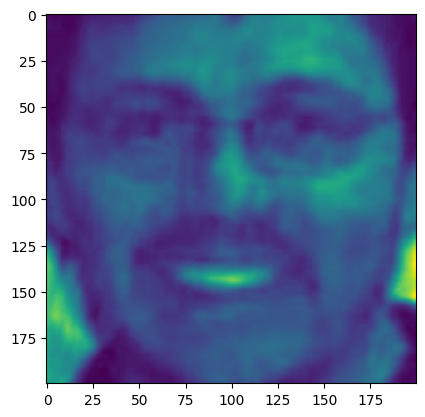

In [3]:
# Sample image
plt.imshow(X[0])

In [4]:
# Target variables are converted in one hot encoding
y = np_utils.to_categorical(y)
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [5]:
# Training and test set are created
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train = np.array(X_train).reshape(-1,200,200,1)
X_test = np.array(X_test).reshape(-1,200,200,1)

### Model preparation and training

In [6]:
# Constant are defined
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE = (IMG_HEIGHT,IMG_WIDTH)

# Hyperparams
batch_size = 256
epochs = 60

In [7]:
# Generate batches of tensor image data with real-time data augmentation.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=15)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow(X_train,y_train,batch_size)
test_data = test_datagen.flow(X_test,y_test,batch_size)

In [8]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
cnn.add(AveragePooling2D(pool_size=(2,2)))
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(132, activation='relu'))
cnn.add(Dense(7, activation='softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.summary()

2022-10-31 00:25:45.471910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 00:25:45.473010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                         

In [9]:
# A checkpoint object is created, it allows to store the model once the training is completed
checkpoint = ModelCheckpoint(filepath="models/cnn_model.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [10]:
# The model is finally trained
history = cnn.fit(train_data,
                    batch_size=batch_size,
                    validation_data=test_data,
                    epochs=epochs,
                    callbacks=[checkpoint],
                    shuffle=False    
                    ) 

Epoch 1/60


2022-10-31 00:25:46.794076: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-31 00:25:47.354783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.8199 - accuracy: 0.2762

2022-10-31 00:26:44.529802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.28240, saving model to cnn_model.h5
92/92 [==============================] - 64s 656ms/step - loss: 1.8199 - accuracy: 0.2762 - val_loss: 1.7666 - val_accuracy: 0.2824
Epoch 2/60
92/92 [==============================] - ETA: 0s - loss: 1.7562 - accuracy: 0.3084
Epoch 2: val_accuracy improved from 0.28240 to 0.32381, saving model to cnn_model.h5
92/92 [==============================] - 58s 621ms/step - loss: 1.7562 - accuracy: 0.3084 - val_loss: 1.7185 - val_accuracy: 0.3238
Epoch 3/60
92/92 [==============================] - ETA: 0s - loss: 1.7246 - accuracy: 0.3199
Epoch 3: val_accuracy improved from 0.32381 to 0.33526, saving model to cnn_model.h5
92/92 [==============================] - 56s 606ms/step - loss: 1.7246 - accuracy: 0.3199 - val_loss: 1.6946 - val_accuracy: 0.3353
Epoch 4/60
92/92 [==============================] - ETA: 0s - loss: 1.7066 - accuracy: 0.3243
Epoch 4: val_accuracy improved from 0.33526 to 0.34043, saving model 

### Results

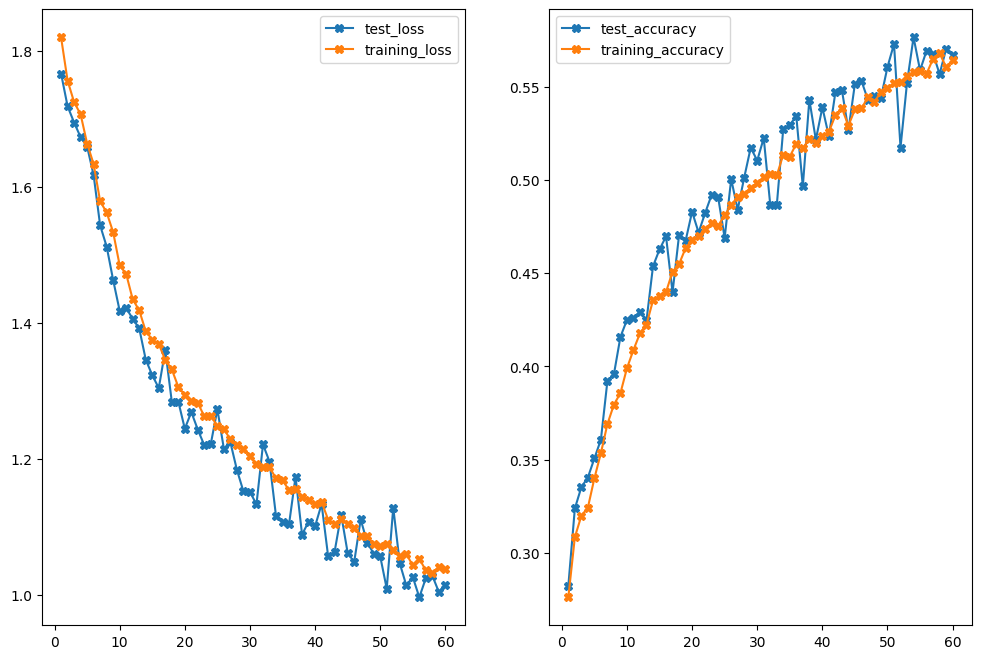

In [11]:
# Training and test loss and accuracy are printed
plotting_data_dict = history.history
plt.figure(figsize=(12,8))
test_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
test_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']
epochs = range(1,len(test_loss)+1)
plt.subplot(121)
plt.plot(epochs,test_loss,marker='X',label='test_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs,test_accuracy,marker='X',label='test_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()